In [1]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

In [2]:
# load data
df = pd.read_csv("../data/aqi_data_labeled.csv")
print (df.head())

     Date  AQI       PM25     Ozone        NO2       SO2        CO  Windspeed  \
0  1/1/21  184  44.270025  0.020213  13.942799  0.527083  0.478506  93.572685   
1  1/2/21   77  14.630556  0.017611  17.015365  0.359028  0.490009  88.252161   
2  1/3/21   82  15.873148  0.018054  14.431703  0.252778  0.476316  80.265124   
3  1/4/21   77  17.684167  0.015154  18.255706  0.313889  0.553226  87.065278   
4  1/5/21   84  19.733333  0.011398  21.868150  0.257639  0.562243  83.821759   

   Temperature AQI_Label  AQI_Class  
0    55.808013    Unsafe          2  
1    53.503846      Safe          0  
2    53.192308      Safe          0  
3    53.570513      Safe          0  
4    53.943910      Safe          0  


In [3]:
# preprocessing 

# convert date column to datetime
# sort by time, which is needed for time-aware ML (no leakage)
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y")
df = df.sort_values("Date")

df = df.drop(columns=["AQI", "AQI_Label"])
df = df.dropna()

In [4]:
# define features + target
features = ["PM25", "Ozone", "NO2", "SO2", "CO", "Windspeed", "Temperature"]
target = "AQI_Class"

X = df[features]
y = df[target]

In [5]:
# handle class imbalance
sample_weights = compute_sample_weight(class_weight = "balanced", y=y)

In [6]:
# train / test split by year
# train on 2021-2022, test on 2023 to prevent temporal leakage

train_df = df[df["Date"] < "2023-01-01"]
test_df = df[df["Date"] >= "2023-01-01"]

X_train = train_df[features].values
y_train = train_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

# Keep DataFrame versions for SHAP
X_train_df = train_df[features]
X_test_df  = test_df[features]

# align weights
w_train = sample_weights[train_df.index]
w_test  = sample_weights[test_df.index]



print("Train size:", X_train.shape, "/ Test size:", X_test.shape)

Train size: (730, 7) / Test size: (365, 7)


In [7]:
param_dist = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.1, 0.05, 0.03, 0.01],
    "n_estimators": [200, 400, 800, 1200, 1600],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 1, 3],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
    "reg_lambda": [0.1, 1.0, 5.0]
}

tscv = TimeSeriesSplit(n_splits=3)

search_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3
)

search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=tscv,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train, sample_weight=w_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, gamma=3, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=1.0, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=3, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=1.0, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=3, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=1.0, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=1600, reg_alpha=0.5, reg_lambda=5.0, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=1600, reg_alpha=0.5, reg_lambda=5.0, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.0

,estimator,"XGBClassifier..._class=3, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 1, ...], 'learning_rate': [0.1, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,30
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [8]:
print("Best params:", search.best_params_)

best_params = search.best_params_

model = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    early_stopping_rounds=50
)

model.fit(
    X_train,
    y_train,
    sample_weight=w_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 1600, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 3, 'colsample_bytree': 1.0}
[0]	validation_0-mlogloss:1.00617
[50]	validation_0-mlogloss:0.33195
[100]	validation_0-mlogloss:0.32475
[150]	validation_0-mlogloss:0.32251
[168]	validation_0-mlogloss:0.32389


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'mlogloss'


In [9]:
# evaluation
preds = model.predict(X_test)

print("CONFUSION MATRIX:")
print(confusion_matrix(y_test, preds))
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, preds))


train_preds = model.predict(X_train)

# check for overfitting
print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Test Accuracy:", accuracy_score(y_test, preds))

CONFUSION MATRIX:
[[262  16   0]
 [ 11  29  12]
 [  1   8  26]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       278
           1       0.55      0.56      0.55        52
           2       0.68      0.74      0.71        35

    accuracy                           0.87       365
   macro avg       0.73      0.75      0.74       365
weighted avg       0.87      0.87      0.87       365

Training Accuracy: 0.8794520547945206
Test Accuracy: 0.8684931506849315


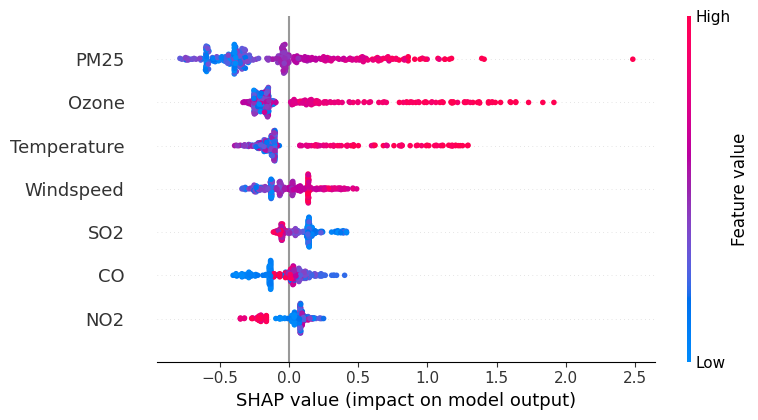

Top-1 unsafe day (test index 205, P(unsafe)=0.924)


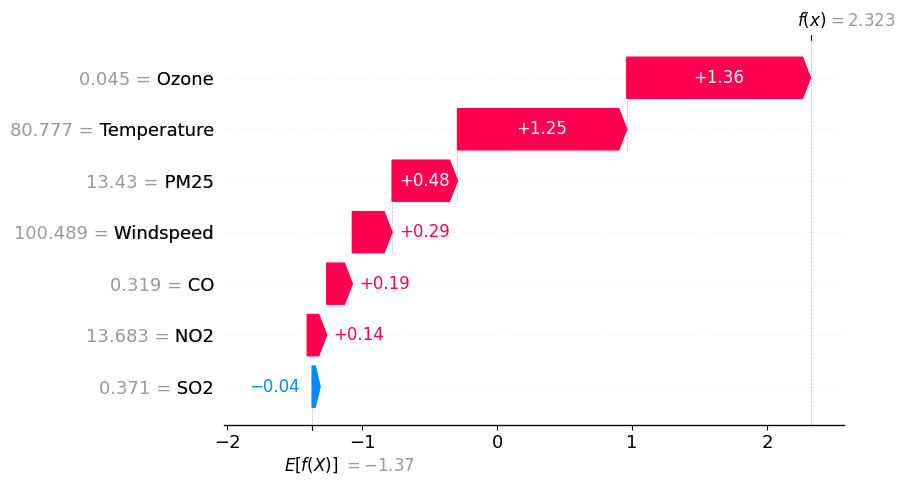

Top-2 unsafe day (test index 181, P(unsafe)=0.919)


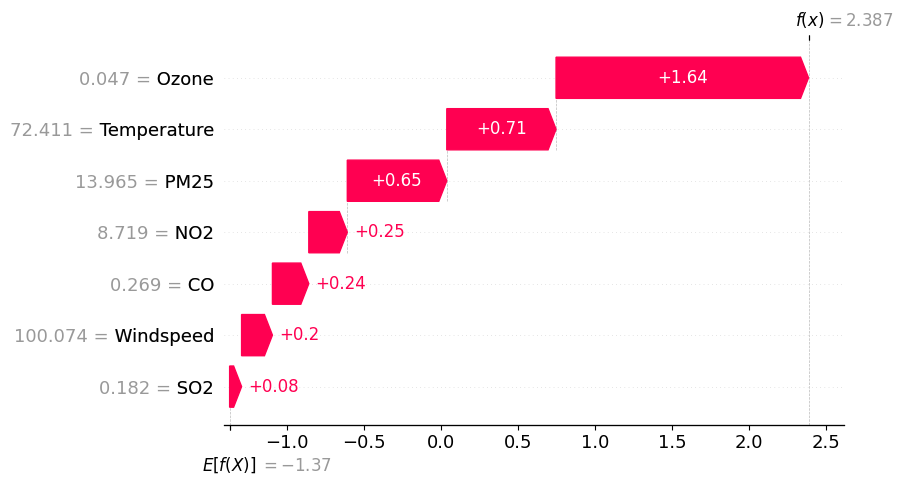

Top-3 unsafe day (test index 194, P(unsafe)=0.905)


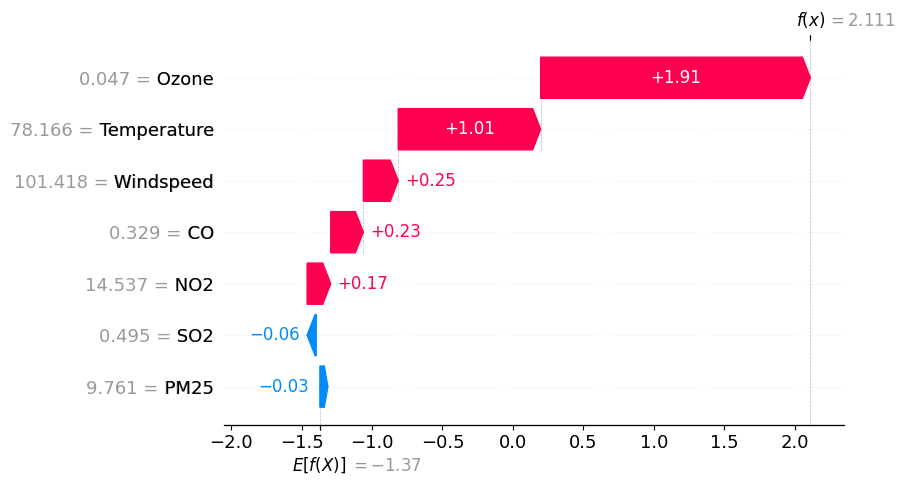

In [10]:
#shap interpretation
import shap
import matplotlib.pyplot as plt

shap.initjs()

#background sample for interventional SHAP
background = X_train_df.sample(min(100, len(X_train_df)), random_state=42)

explainer = shap.TreeExplainer(
    model,
    background,
    feature_perturbation="interventional"
)

shap_values_raw = explainer.shap_values(
    X_test_df,
    check_additivity=False
)

# want to focus on unsafe days
# i dont know if we are using this method to seperate the classes
class_names = ["safe", "caution", "unsafe"]
unsafe_idx = 2  # index for "unsafe" class

# Normalize shap_values into (n_samples, n_features) for the unsafe class
if isinstance(shap_values_raw, list):
    # classic SHAP multi-class: list of arrays
    shap_values_unsafe = shap_values_raw[unsafe_idx]
else:
    vals = np.asarray(shap_values_raw)
    if vals.ndim == 3:
        shap_values_unsafe = vals[:, :, unsafe_idx]
    elif vals.ndim == 2:
        shap_values_unsafe = vals
    else:
        raise ValueError(f"Unexpected shap_values shape: {vals.shape}")

# print("shap_values_unsafe shape:", shap_values_unsafe.shape)
# print("X_test_df shape:", X_test_df.shape)

#global plot
shap.summary_plot(
    shap_values_unsafe,
    X_test_df,
    feature_names=features,
    show=True
)

# waterfall plots for top unsafe days
probs = model.predict_proba(X_test_df.values)   # shape: (n_samples, 3)
unsafe_probs = probs[:, unsafe_idx]

# indices of true unsafe days in test set
unsafe_test_indices = np.where(y_test == unsafe_idx)[0]

# sort those unsafe days by predicted P(unsafe), descending
sorted_unsafe_indices = unsafe_test_indices[np.argsort(-unsafe_probs[unsafe_test_indices])]

max_plots = 3  # top 3 unsafe days can change to however we want
n_plots = min(max_plots, len(sorted_unsafe_indices))

for k in range(n_plots):
    i = sorted_unsafe_indices[k]
    print(f"Top-{k+1} unsafe day (test index {i}, P(unsafe)={unsafe_probs[i]:.3f})")

    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_unsafe[i],
            base_values=explainer.expected_value[unsafe_idx],
            data=X_test_df.iloc[i],
            feature_names=features
        )
    )

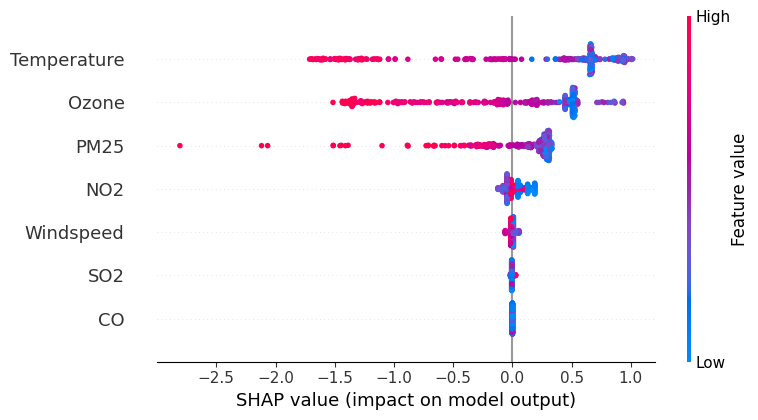

Top-1 clean (safe) day (test index 31, P(safe)=0.971)


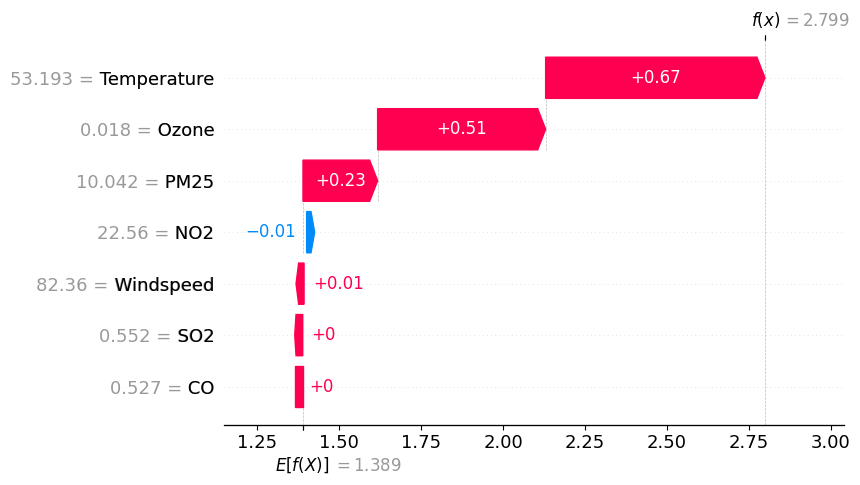

Top-2 clean (safe) day (test index 23, P(safe)=0.971)


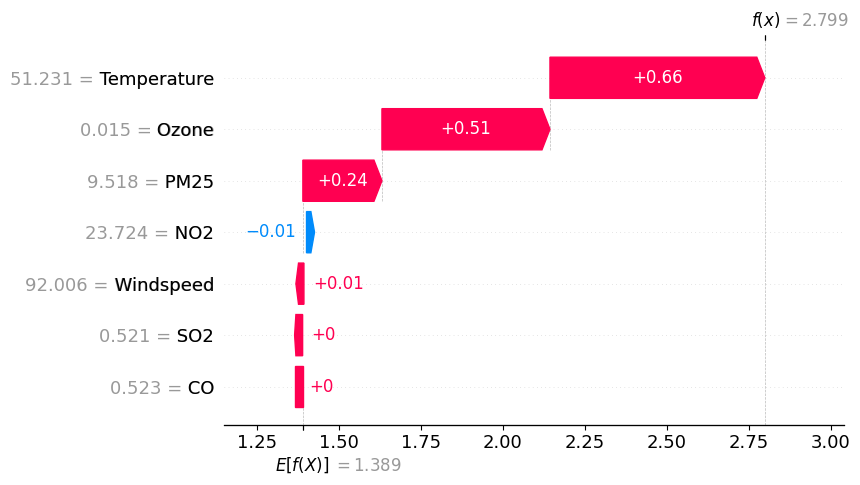

Top-3 clean (safe) day (test index 331, P(safe)=0.971)


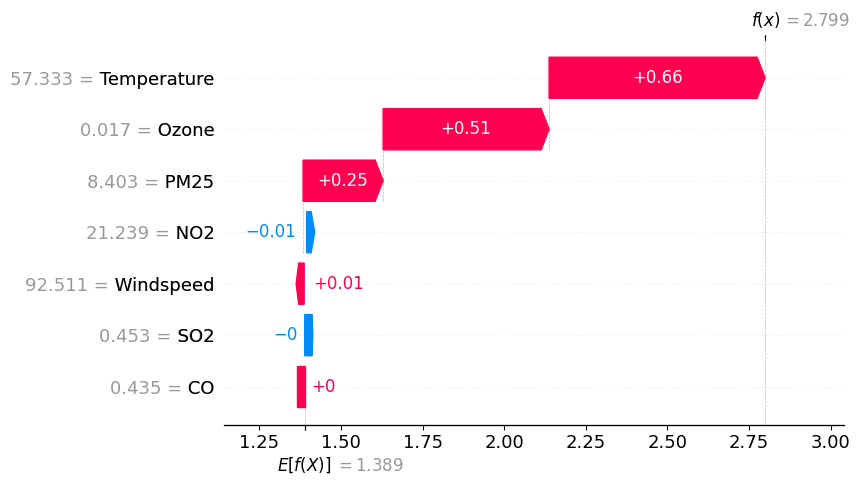

In [11]:
safe_idx = 0  # index for "safe" class

# Get SHAP values for the safe class
if isinstance(shap_values_raw, list):
    shap_values_safe = shap_values_raw[safe_idx]
else:
    vals = np.asarray(shap_values_raw)
    if vals.ndim == 3:
        shap_values_safe = vals[:, :, safe_idx]
    elif vals.ndim == 2:
        shap_values_safe = vals
    else:
        raise ValueError(f"Unexpected shap_values shape: {vals.shape}")

# Global SHAP summary for SAFE class
shap.summary_plot(
    shap_values_safe,
    X_test_df,
    feature_names=features,
    show=True
)

# Probabilities for SAFE class
safe_probs = probs[:, safe_idx]

# indices of true SAFE days in test set
safe_test_indices = np.where(y_test == safe_idx)[0]

# sort those safe days by predicted P(safe), descending
sorted_safe_indices = safe_test_indices[np.argsort(-safe_probs[safe_test_indices])]

max_safe_plots = 3  # number of top clean days to visualize
n_safe_plots = min(max_safe_plots, len(sorted_safe_indices))

for k in range(n_safe_plots):
    i = sorted_safe_indices[k]
    print(f"Top-{k+1} clean (safe) day (test index {i}, P(safe)={safe_probs[i]:.3f})")

    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_safe[i],
            base_values=explainer.expected_value[safe_idx],
            data=X_test_df.iloc[i],
            feature_names=features
        )
    )